In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages (if not already installed)
!pip install transformers datasets torch torchvision scikit-learn
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [1]:
# Import Necessary Libraries

import pandas as pd
import torch
from torch import nn

from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm

from torch.optim import AdamW

from collections import deque
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

from collections import Counter
import seaborn as sns
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import ks_2samp

from captum.attr import IntegratedGradients
from sklearn.calibration import calibration_curve

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/phishingdataset/SpamAssasin.csv")

# Remove null values
df = df.dropna()

# Drop date
if df.columns.str.contains('date').any():
  df = df.drop('date', axis=1)

# Convert data to X and Y variables
X = df['body'].tolist()
Y = df['label'].tolist()

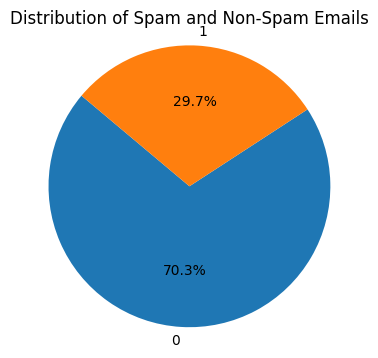

In [ ]:
# Plot data distribution
plt.figure(figsize=(4, 4))
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Extract embeddings from BERT of the dataset to make processing faster

# Load tokenizer and frozen BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()
for param in bert.parameters():
    param.requires_grad = False
bert.to(device)

# Create Dataset & Dataloader
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)}
dataset = TextDataset(X, Y, tokenizer)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Get [CLS] embeddings
all_embeddings = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(loader, desc="Extracting embeddings"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['label']
        outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        all_embeddings.append(cls_embeddings.cpu())
        all_labels.append(label)

# Stack embeddings and save the file
all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)
torch.save({'embeddings': all_embeddings, 'labels': all_labels}, 'spamassasin_bert_embeddings.pt')
print("Saved embeddings to 'spamassasin_bert_embeddings.pt'")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# Extract embeddings from .pt file
data = torch.load('/content/drive/MyDrive/Colab Notebooks/spamassasin_bert_embeddings.pt')
X = data['embeddings']  # Shape: [num_samples, 768]
Y = data['labels']      # Shape: [num_samples]

In [6]:
# Create tensor dataset
dataset = TensorDataset(X, Y)

# Calculate sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split into train, val, test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)   # For DQN agent
test_loader = DataLoader(test_dataset, batch_size=64) # For final metrics

In [7]:
# Frozen BERT Classifier
# We are using a simple Multi-Layer Perceptron over the BERT-computed embeddings for classification
class FrozenBERTClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=2):
        super(FrozenBERTClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes))
    def forward(self, x):  # x is the precomputed embeddings [batch_size, 768]
        return self.classifier(x)

model = FrozenBERTClassifier().to(device)

In [8]:
# Training BERT - Supervised Pre-training

train_losses = []
val_accuracies = []
action_history = []
reward_history = []

optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 10

# Training loop for FrozenBERT
def train_frozen_bert(model, dataloader):
    model.train()  # Set model to training mode
    total_loss = 0  # Track the total loss for the epoch
    for batch in dataloader:
        embeddings, labels = [x.to(device) for x in batch]
        # Forward pass with precomputed embeddings
        outputs = model(embeddings)  # Directly use the embeddings
        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()  # Accumulate loss for averaging
    avg_loss = total_loss / len(dataloader)  # Average loss for the epoch
    train_losses.append(avg_loss)  # Store average loss for tracking
    print(f"Training Loss: {avg_loss:.4f}")

In [9]:
# Validation Accuracy for FrozenBERT
def evaluate_accuracy(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Don't compute gradients during evaluation
        for batch in dataloader:
            embeddings, labels = [x.to(device) for x in batch]

            # Forward pass with precomputed embeddings
            outputs = model(embeddings)  # Directly use the embeddings

            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = correct / total * 100
    val_accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.2f}%")

In [10]:
# Training Loop for FrozenBERT
for epoch in range(epochs):
    train_frozen_bert(model, train_loader)  # Use the FrozenBERT training function
    evaluate_accuracy(model, val_loader)  # Evaluate the accuracy after each epoch
    print(f"Epoch {epoch+1} done.")

Training Loss: 0.4845
Validation Accuracy: 82.20%
Epoch 1 done.
Training Loss: 0.3111
Validation Accuracy: 90.56%
Epoch 2 done.
Training Loss: 0.2264
Validation Accuracy: 93.67%
Epoch 3 done.
Training Loss: 0.1851
Validation Accuracy: 94.38%
Epoch 4 done.
Training Loss: 0.1600
Validation Accuracy: 94.27%
Epoch 5 done.
Training Loss: 0.1488
Validation Accuracy: 95.22%
Epoch 6 done.
Training Loss: 0.1357
Validation Accuracy: 95.58%
Epoch 7 done.
Training Loss: 0.1274
Validation Accuracy: 95.10%
Epoch 8 done.
Training Loss: 0.1206
Validation Accuracy: 95.46%
Epoch 9 done.
Training Loss: 0.1132
Validation Accuracy: 95.58%
Epoch 10 done.


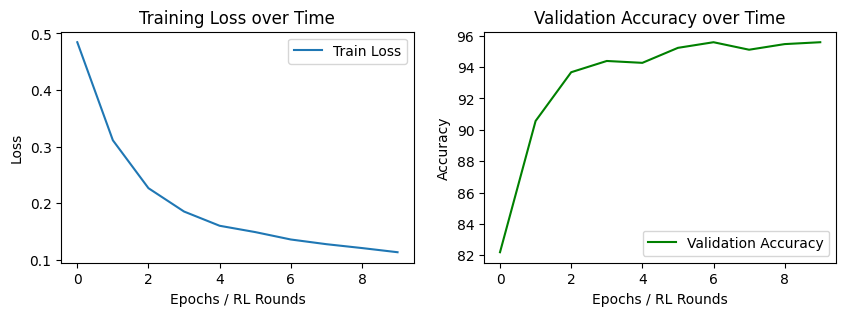

In [11]:
# Plot Training Loss and Validation Accuracy of BERT Classifier
# Training loss
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss over Time")
plt.xlabel("Epochs / RL Rounds")
plt.ylabel("Loss")
plt.legend()
# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.title("Validation Accuracy over Time")
plt.xlabel("Epochs / RL Rounds")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
# Evaluate FrozenBERT model
def get_preds(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    for batch in dataloader:
        embeddings, labels = [x.to(device) for x in batch]

        with torch.no_grad():  # Disable gradient calculation during evaluation
            outputs = model(embeddings)  # Pass precomputed embeddings directly to the model

        preds = torch.argmax(outputs, dim=1)  # Get predicted class labels
        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

    return all_preds, all_labels

In [13]:
# Before training/fine-tuning with DQN
bert_preds, y_true = get_preds(model, test_loader)

In [14]:
# Matthews Correlation Coefficient (MCC) – good for imbalanced classes
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_true, bert_preds))

Matthews Correlation Coefficient: 0.8664363967095587


In [15]:
# Classification Metrics
print(classification_report(y_true, bert_preds, target_names=["Non-Spam", "Spam"]))

              precision    recall  f1-score   support

    Non-Spam       0.95      0.96      0.96       554
        Spam       0.92      0.90      0.91       284

    accuracy                           0.94       838
   macro avg       0.93      0.93      0.93       838
weighted avg       0.94      0.94      0.94       838



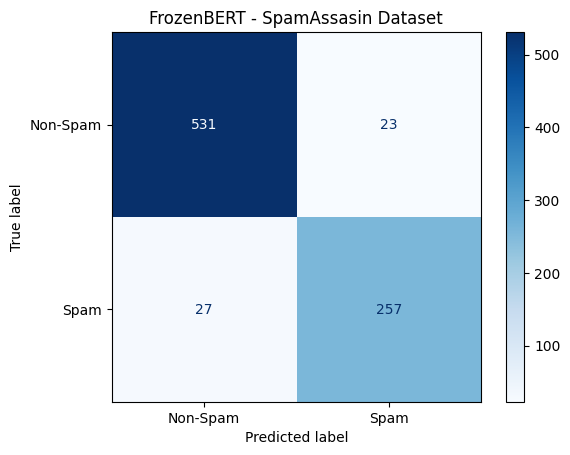

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, bert_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if you like
plt.title("FrozenBERT - SpamAssasin Dataset")
plt.show()

In [17]:
# DQN Agent to control BERT Fine-tuning

class DQNAgent:
    def __init__(self, state_size=1, action_size=2):
        self.state_size = state_size  # Accuracy, error rate, etc.
        self.action_size = action_size  # 0 = do nothing, 1 = fine-tune BERT
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        self.lr = 0.001
        self.model = self._build_model()

    def _build_model(self):
        return nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        ).to(device)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state in minibatch:
            target = reward + self.gamma * torch.max(self.model(torch.FloatTensor(next_state).unsqueeze(0).to(device))).item()
            target_f = self.model(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy()
            target_f[0][action] = target

            output = self.model(torch.FloatTensor(state).unsqueeze(0).to(device))
            loss = nn.MSELoss()(output, torch.FloatTensor(target_f).to(device))
            loss.backward()
            for param in self.model.parameters():
                param.data -= self.lr * param.grad
            self.model.zero_grad()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [18]:
def unfreeze_frozenbert(model, epoch, total_epochs, state):
    """
    Gradually unfreezes FrozenBERT layers.
    - First 1/3 epochs: all frozen.
    - After 1/3 epochs: unfreeze classifier.
    - After 2/3 epochs: unfreeze entire model.
    'state' is a dict to track what's already been unfrozen.
    """
    if epoch >= total_epochs // 3 and not state.get("classifier_unfrozen", False):
        for param in model.classifier.parameters():
            param.requires_grad = True
        state["classifier_unfrozen"] = True
        print(f"[INFO] Unfreezing classifier layers after epoch {epoch}")
    if epoch >= (2 * total_epochs) // 3 and not state.get("all_unfrozen", False):
        for param in model.parameters():
            param.requires_grad = True  # Unfreeze all layers
        state["all_unfrozen"] = True
        print(f"[INFO] Unfreezing all layers after epoch {epoch}")
    return model

In [19]:
# DQN Action during Evaluation

EPISODES = 10
unfreeze_state = {"classifier_unfrozen": False, "all_unfrozen": False}

agent = DQNAgent()

def evaluate_and_learn(model, val_loader, agent, epoch, epochs, unfreeze_state):
    model.eval()
    correct = 0
    total = 0
    fine_tuned = False  # Flag to track if fine-tuning has been triggered during this evaluation

    # To store per-batch val_accuracies
    per_batch_accuracies = []

    for batch in val_loader:
        embeddings, labels = [x.to(device) for x in batch]
        with torch.no_grad():
            outputs = model(embeddings)  # Use precomputed embeddings for FrozenBERT
        preds = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Calculate error rate based on correct predictions
        error_rate = 1 - (correct / total)

        # Calculate accuracy for the current batch
        batch_accuracy = correct / total
        per_batch_accuracies.append(batch_accuracy)  # Store per-batch accuracy

        # Take RL action based on the error rate
        action = agent.act([error_rate])

        # Reward function: correct prediction => +1, incorrect prediction => -1
        reward = 1 if preds.equal(labels) else -1

        # Remember the state, action, reward, next state for replay
        agent.remember([error_rate], action, reward, [error_rate])
        action_history.append(action)
        reward_history.append(reward)

        # Trigger fine-tuning based on error rate and action
        if action == 1 and not fine_tuned and error_rate > 0.005:
            print(f"[DQN] Triggering fine-tune due to error rate: {error_rate:.4f}")
            unfreeze_frozenbert(model, epoch, epochs, unfreeze_state)
            train_frozen_bert(model, train_loader)
            fine_tuned = True

    # Update val_accuracies at the end of evaluation
    val_accuracies.extend(per_batch_accuracies)  # Add per-batch accuracies to the list

    agent.replay()

# DQN+BERT Training Loop
for epoch in range(EPISODES):
    print(f"\n[Epoch {epoch+1}/{EPISODES}] Starting training...")

    # Step 1: Train the model (initially FrozenBERT or partially unfrozen)
    train_frozen_bert(model, train_loader)

    # Step 2: Evaluate using DQN and possibly trigger fine-tuning
    evaluate_and_learn(model, val_loader, agent, epoch, EPISODES, unfreeze_state)

    # Optional: Evaluate overall validation performance
    evaluate_accuracy(model, val_loader)


[Epoch 1/10] Starting training...
Training Loss: 0.1106
[DQN] Triggering fine-tune due to error rate: 0.0312
Training Loss: 0.1059
Validation Accuracy: 95.46%

[Epoch 2/10] Starting training...
Training Loss: 0.1028
[DQN] Triggering fine-tune due to error rate: 0.0469
Training Loss: 0.0984
Validation Accuracy: 95.70%

[Epoch 3/10] Starting training...
Training Loss: 0.0954
[DQN] Triggering fine-tune due to error rate: 0.0312
Training Loss: 0.0950
Validation Accuracy: 96.18%

[Epoch 4/10] Starting training...
Training Loss: 0.0905
[DQN] Triggering fine-tune due to error rate: 0.0234
[INFO] Unfreezing classifier layers after epoch 3
Training Loss: 0.0868
Validation Accuracy: 95.82%

[Epoch 5/10] Starting training...
Training Loss: 0.0860
[DQN] Triggering fine-tune due to error rate: 0.0273
Training Loss: 0.0830
Validation Accuracy: 96.30%

[Epoch 6/10] Starting training...
Training Loss: 0.0833
[DQN] Triggering fine-tune due to error rate: 0.0234
Training Loss: 0.0799
Validation Accurac

In [20]:
# Get Model Performance Metrics
def model_results(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    for batch in dataloader:
        embeddings, labels = [x.to(device) for x in batch]
        with torch.no_grad():
            outputs = model(embeddings)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # P(spam)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)

    # Per-Class Accuracy
    def per_class_accuracy(y_true, y_pred):
      classes = set(y_true)
      for cls in classes:
        idx = [i for i, label in enumerate(y_true) if label == cls]
        acc = accuracy_score([y_true[i] for i in idx], [y_pred[i] for i in idx])
        print(f"Accuracy for class {cls}:", acc)
    per_class_accuracy(all_labels, all_preds)

    # Matthews Correlation Coefficient (MCC) – good for imbalanced classes
    print("Matthews Correlation Coefficient:", matthews_corrcoef(all_labels, all_preds))

    return all_preds, all_labels, all_probs, fpr, tpr, roc_auc, precision, recall

# Performance after training and RL evaluation
all_preds, all_labels, all_probs, fpr, tpr, roc_auc, precision, recall = model_results(model, test_loader)

Accuracy for class 0: 0.9747292418772563
Accuracy for class 1: 0.9330985915492958
Matthews Correlation Coefficient: 0.9118208960018535


In [21]:
# Classification Report
print(classification_report(all_labels, all_preds, target_names=["Non-Spam", "Spam"]))

              precision    recall  f1-score   support

    Non-Spam       0.97      0.97      0.97       554
        Spam       0.95      0.93      0.94       284

    accuracy                           0.96       838
   macro avg       0.96      0.95      0.96       838
weighted avg       0.96      0.96      0.96       838



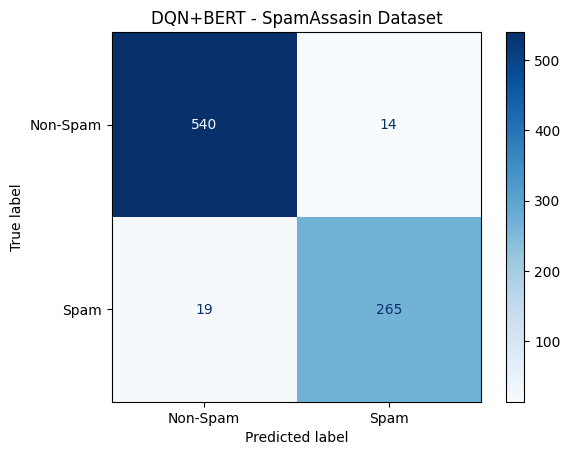

In [22]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if you like
plt.title("DQN+BERT - SpamAssasin Dataset")
plt.show()

In [ ]:
# McNemar’s Test - compares performance of two classifiers on same dataset
def run_mcnemar(y_true, bert_preds, dqn_preds):
    table = [[0, 0], [0, 0]]
    for yt, b, d in zip(y_true, bert_preds, dqn_preds):
        if b == yt and d == yt:
            table[0][0] += 1
        elif b == yt and d != yt:
            table[0][1] += 1
        elif b != yt and d == yt:
            table[1][0] += 1
        else:
            table[1][1] += 1

    result = mcnemar(table, exact=True)
    print("McNemar’s Test:", result.pvalue)
run_mcnemar(all_labels, bert_preds, all_preds)

McNemar’s Test: 2.744048833847046e-05


In [ ]:
# Kolmogorov–Smirnov test – compare distribution of predicted vs actual classes
def ks_test(pred_probs, true_labels):
    result = ks_2samp(pred_probs, true_labels)
    print("K-S Test Statistic:", result.statistic)
    print("p-value:", result.pvalue)
ks_test(all_probs, all_labels)

K-S Test Statistic: 0.6801909307875895
p-value: 6.609116038310633e-185


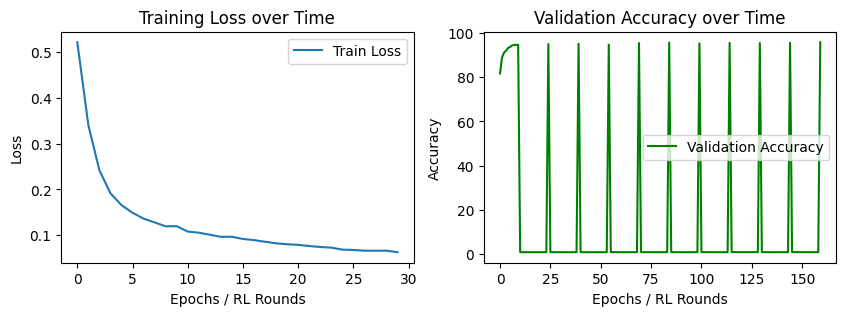

In [ ]:
# Performance Plots
# Training loss
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss over Time")
plt.xlabel("Epochs / RL Rounds")
plt.ylabel("Loss")
plt.legend()
# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.title("Validation Accuracy over Time")
plt.xlabel("Epochs / RL Rounds")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

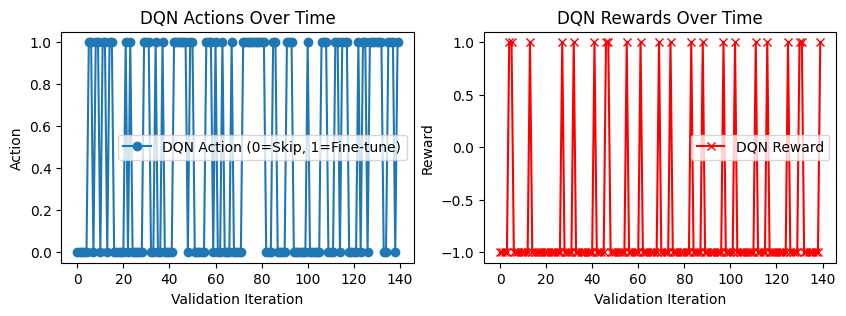

In [ ]:
# DQN Actions
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(action_history, label="DQN Action (0=Skip, 1=Fine-tune)", marker='o')
plt.title("DQN Actions Over Time")
plt.xlabel("Validation Iteration")
plt.ylabel("Action")
plt.legend()
# DQN Rewards
plt.subplot(1, 2, 2)
plt.plot(reward_history, label="DQN Reward", color="red", marker='x')
plt.title("DQN Rewards Over Time")
plt.xlabel("Validation Iteration")
plt.ylabel("Reward")
plt.legend()
plt.show()

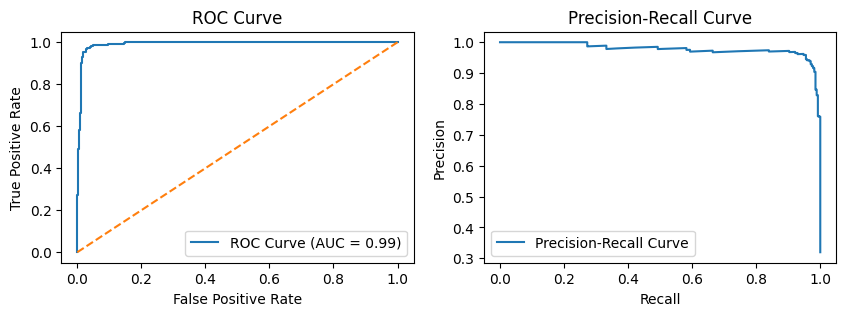

In [ ]:
# ROC Curve
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

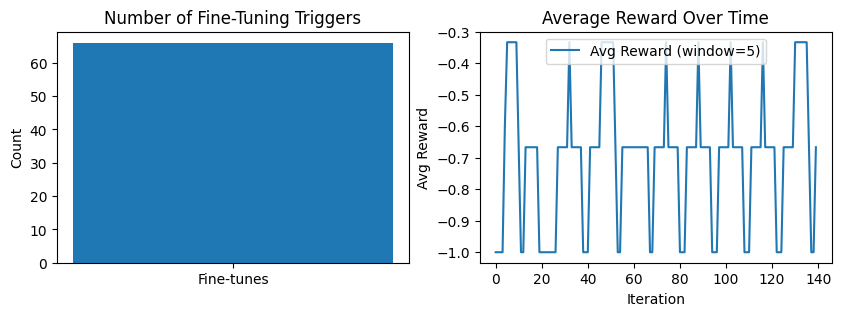

In [ ]:
# Count of fine-tuning
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(['Fine-tunes'], [action_history.count(1)])
plt.title("Number of Fine-Tuning Triggers")
plt.ylabel("Count")
# Average Reward Per Episode
window = 5  # or 10
avg_rewards = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.subplot(1, 2, 2)
plt.plot(avg_rewards, label="Avg Reward (window=5)")
plt.title("Average Reward Over Time")
plt.xlabel("Iteration")
plt.ylabel("Avg Reward")
plt.legend()
plt.show()

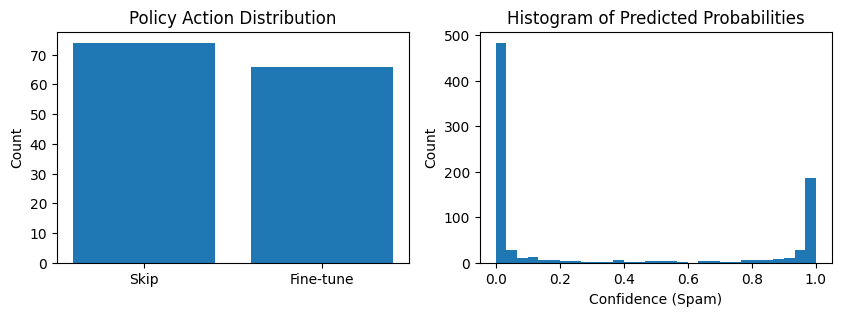

In [ ]:
# Action Distribution
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
action_counts = Counter(action_history)
plt.bar(action_counts.keys(), action_counts.values(), tick_label=["Skip", "Fine-tune"])
plt.title("Policy Action Distribution")
plt.ylabel("Count")
# Visualization: Histogram of Logits/Probabilities - especially useful to detect overconfidence
def plot_logits_hist(model, dataloader):
    model.eval()
    all_logits = []
    for batch in dataloader:
        embeddings, labels = [x.to(device) for x in batch]
        with torch.no_grad():
            logits = model(embeddings)
        all_logits.extend(torch.softmax(logits, dim=1).cpu().numpy())
    probs = np.array(all_logits)[:, 1]  # Prob spam
    return probs
probs = plot_logits_hist(model, test_loader)
plt.subplot(1, 2, 2)
plt.hist(probs, bins=30)
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Confidence (Spam)")
plt.ylabel("Count")
plt.show()

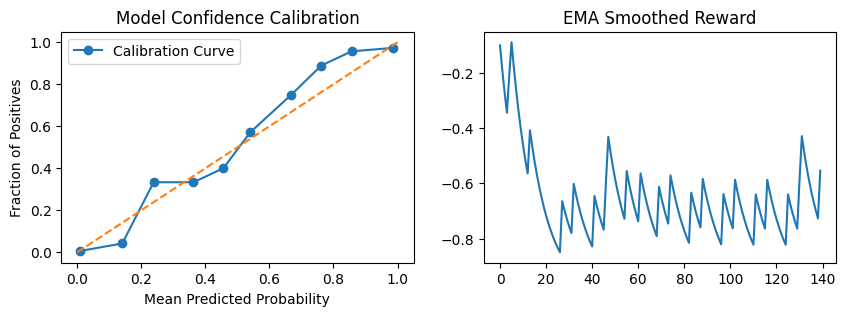

In [ ]:
# Visualization: Confidence Calibration Plot - is the model's confidence well-calibrated?
def plot_calibration(model, dataloader):
    model.eval()
    y_probs, y_true = [], []
    for batch in dataloader:
        embeddings, labels = [x.to(device) for x in batch]
        with torch.no_grad():
            probs = torch.softmax(model(embeddings), dim=1)
        y_probs.extend(probs[:, 1].cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    return y_probs, y_true
y_probs, y_true = plot_calibration(model, test_loader)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Model Confidence Calibration")
plt.legend()
# Reward Trend Line with Smoothing (EMA)
def plot_smoothed_rewards(rewards, alpha=0.1):
    ema = []
    smoothed = 0
    for r in rewards:
        smoothed = alpha * r + (1 - alpha) * smoothed
        ema.append(smoothed)
    return ema
ema = plot_smoothed_rewards(reward_history)
plt.subplot(1, 2, 2)
plt.plot(ema)
plt.title("EMA Smoothed Reward")
plt.show()

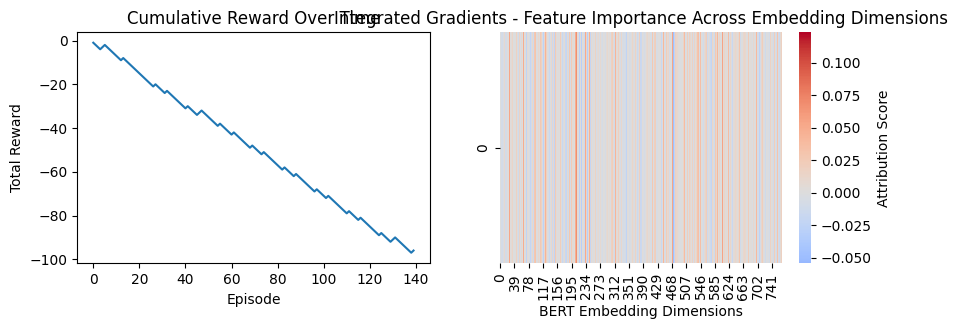

In [ ]:
# Cumulative Reward Plot
cum_rewards = np.cumsum(reward_history)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(cum_rewards)
plt.title("Cumulative Reward Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
# Saliency Maps / Integrated Gradients - show which tokens influenced decisions
def plot_embedding_saliency(model, embedding_input, target_class):
    model.eval()
    embedding_input = embedding_input.unsqueeze(0).to(device)  # Shape: [1, 768]
    ig = IntegratedGradients(model)
    attributions, _ = ig.attribute(embedding_input, target=target_class, return_convergence_delta=True)
    attributions = attributions.squeeze().detach().cpu().numpy()
    return attributions
# Plotting the saliency map (embedding dimensions)

# Suppose you want to visualize sample #42 from your test set
sample_idx = 42
embedding_input = test_dataset[sample_idx][0]  # shape: [768]
target_class = test_dataset[sample_idx][1].item()  # scalar: 0 or 1
attributions = plot_embedding_saliency(model, embedding_input, target_class)
plt.subplot(1, 2, 2)
sns.heatmap([attributions], cmap='coolwarm', center=0, cbar_kws={'label': 'Attribution Score'})
plt.xlabel("BERT Embedding Dimensions")
plt.title("Integrated Gradients - Feature Importance Across Embedding Dimensions")
plt.show()